# Library

In [2]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import tensorflow as tf

import matplotlib.font_manager as fm

font_dirs = ['/usr/share/fonts/truetype/nanum', ]
font_files = fm.findSystemFonts(fontpaths=font_dirs)

for font_file in font_files:
    fm.fontManager.addfont(font_file)
    
sns.set(font="NanumBarunGothic", 
        rc={"axes.unicode_minus":False},
        style='white')

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

gpus = tf.config.experimental.list_physical_devices('GPU')
print(gpus)
if gpus:
    try:
        for i in range(len(gpus)):
            tf.config.experimental.set_memory_growth(gpus[i], True)
    except RuntimeError as e:
        print(e)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]


# Define Visualization Function

In [4]:
feature_df = pd.read_csv('feature_df.csv')
feature_name = dict(zip(feature_df['feature'], feature_df['feature_name']))

X = np.load('x_(7727,10,4068).npy')
y = np.load('/project/LSH/y_(7727,1).npy')
COLS = list(pd.read_csv('/project/LSH/total_data_7727.csv')['ITEMID'].sort_values().unique())

d_index = np.where(y==1)[0]
s_index = np.where(y==0)[0]

d_X = X[d_index]
s_X = X[s_index]

result = []
result_s = []

for d in range(10):
    for f in range(d_X.shape[-1]):
        d_sum = d_X[:,d,f].sum()/d_X.shape[0]
        s_sum = s_X[:,d,f].sum()/s_X.shape[0]
        result.append({'cols':COLS[f], 'day':10-d,'per':d_sum})
        result_s.append({'cols':COLS[f], 'day':10-d,'per':s_sum})
        
d_df = pd.DataFrame(result).sort_values(['cols','day']).reset_index(drop=True)
s_df = pd.DataFrame(result_s).sort_values(['cols','day']).reset_index(drop=True)
d_df.shape, s_df.shape

def absum(top10_list):
    plt.figure(figsize = (17,6), dpi=300)
    i = 0
    for f in top10_list:
        if f == 0:
            continue
        plt.subplot(2,5,1+i)
        plt.title(feature_name[f])
        ax = sns.lineplot(data = d_df[d_df['cols']==int(f)], x = 'day', y='per', label='dead')
        ax = sns.lineplot(data = s_df[s_df['cols']==int(f)], x = 'day', y='per', label='survivor', linestyle=':', marker='o')
        ax.invert_xaxis()
        ax.legend(loc='upper left')
        i += 1
    plt.tight_layout()

((40680, 3), (40680, 3))

# RandomForest FI
- `scikit-learn`Random Forest : [three methods to calculate Feature Importance](https://mljar.com/blog/feature-importance-in-random-forest/)
    1. built-in feature importance
    2. permutaion based importance
    3. importance computed with SHAP values

# RF - ① built-in
- Using the built-in Feature Importance functionality in RF requires a post-hoc determination of the distinction between death and survival markers.

## x_(7727, 4068)

In [86]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
import shap

import random  
seed_num = 42
random.seed(seed_num)

x = np.load('x_(7727,4068).npy')
y = np.load('/project/LSH/y_(7727,1).npy')

idx = list(range(len(x)))
random.shuffle(idx)

i = round(x.shape[0]*0.8)
X_train, y_train = x[idx[:i],:], y[idx[:i]]
X_test, y_test = x[idx[i:],:], y[idx[i:]]

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((6182, 4068), (6182,), (1545, 4068), (1545,))

RandomForestClassifier()

정확도 : 0.7346278317152104, Precision : 0.7267950963222417, Recall : 0.8943965517241379, F1 : 0.8019323671497584, roc_auc : 0.6943619711619069


,feature,score
206,51277,0.016387
121,51006,0.011396
56,50912,0.009573
20,50862,0.006272
103,50983,0.006102
3832,63323026201,0.006000
119,51003,0.005836
204,51275,0.005655
184,51244,0.005622
8,50813,0.005233


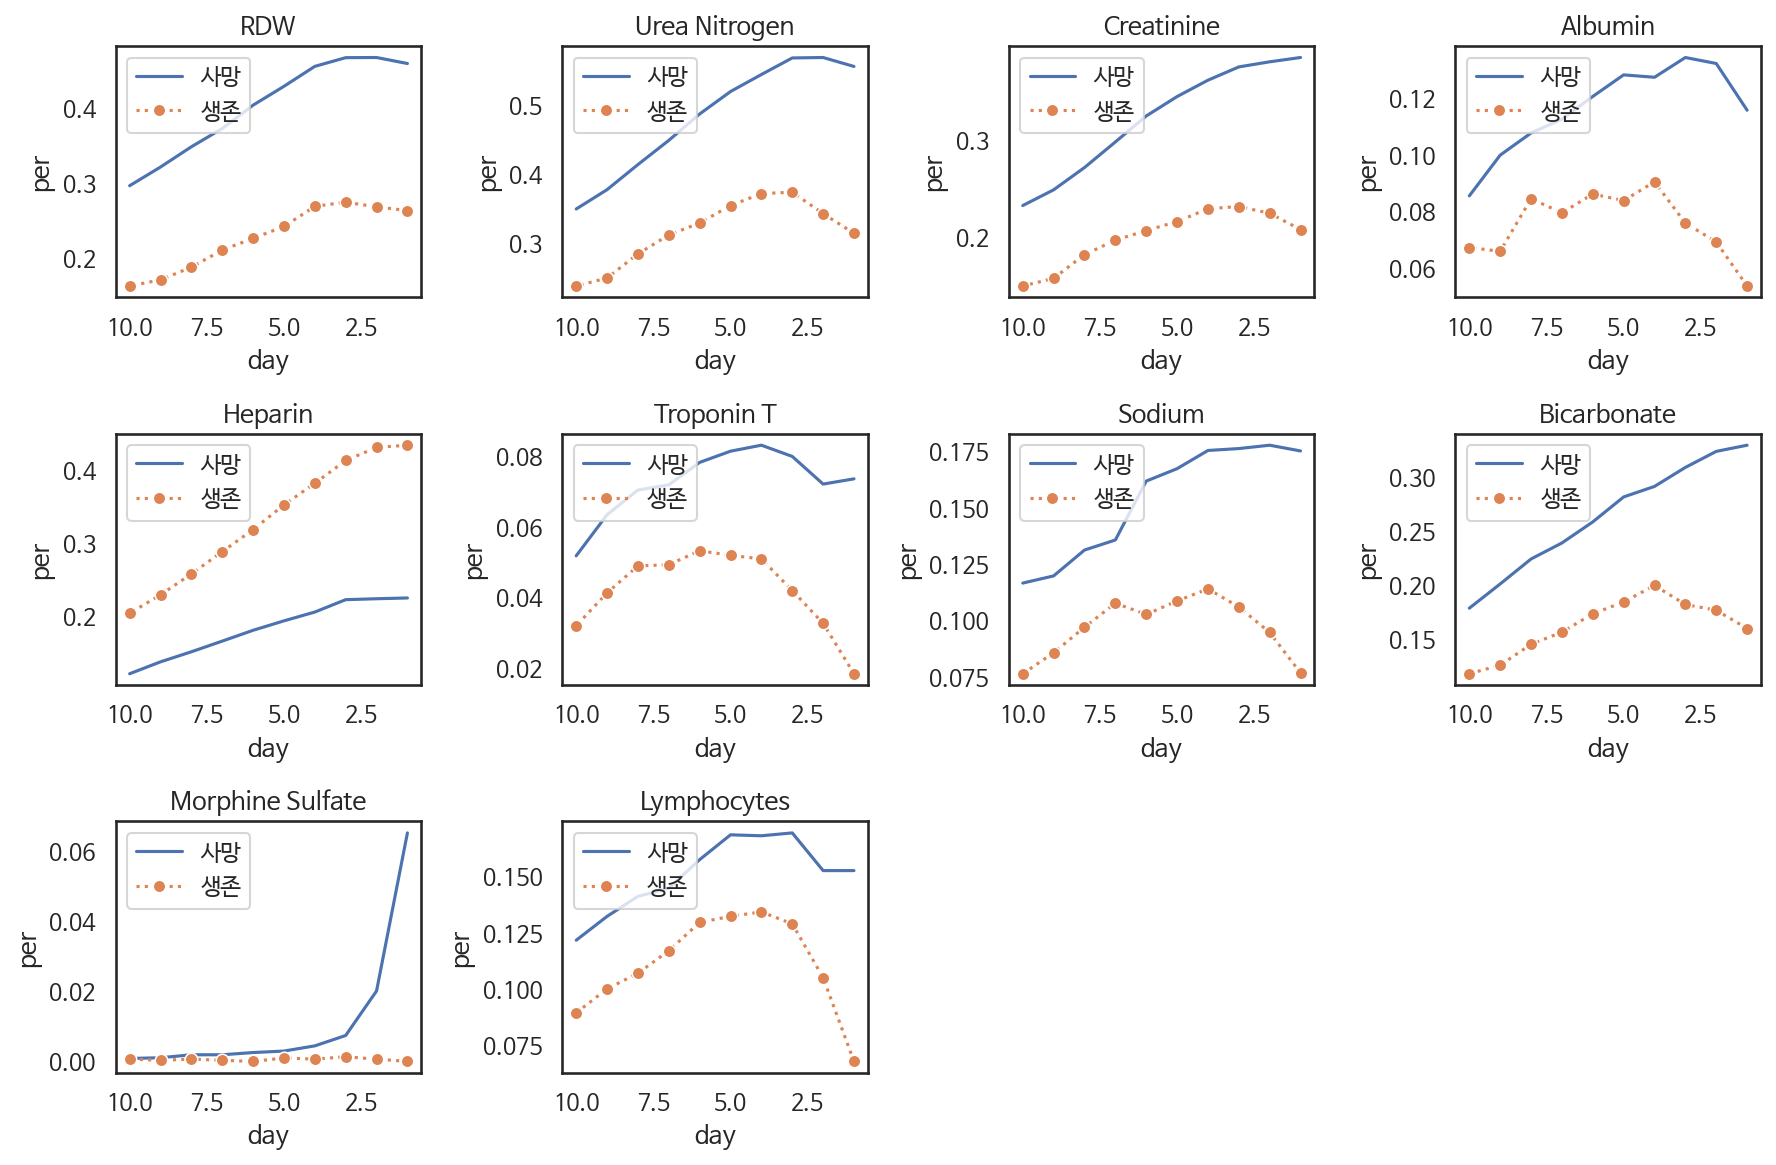

In [89]:
# 1. Define RF model and measure performance
model = RandomForestClassifier()
model.fit(X_train, y_train)
pred = model.predict(X_test)

precision = precision_score(y_test, pred)
recall = recall_score(y_test, pred)
f1 = f1_score(y_test, pred)
roc_auc = roc_auc_score(y_test, pred)
acc = accuracy_score(y_test, pred)

print(f'Accuracy : {acc}, Precision : {precision}, Recall : {recall}, F1 : {f1}, roc_auc : {roc_auc}')

# 2. Create FI df
features = list(pd.read_csv('/project/LSH/total_data_7727.csv')['ITEMID'].sort_values().unique())
df = pd.DataFrame(features, columns=['feature'])
df['score'] = model.feature_importances_
df = df.sort_values(by = 'score', ascending = False)
df[:10]

# df.to_csv('RF_FI_4068.csv', index = False)

# 3. absum graph
df = pd.read_csv('RF_FI_4068.csv')
absum(df['feature'][:10])

## x_(7727, 3595)

In [77]:
# Create x_(7727, 3595).npy
x1 = np.load('x_(7727,10,3595).npy')
x1 = x1.sum(axis=1)
x1[x1>1] = 1

# np.save('x_(7727,3595).npy', x1)

In [78]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
import shap

import random  
seed_num = 42
random.seed(seed_num)

x = np.load('x_(7727,3595).npy')
y = np.load('/project/LSH/y_(7727,1).npy')

idx = list(range(len(x)))
random.shuffle(idx)

i = round(x.shape[0]*0.8)
X_train, y_train = x[idx[:i],:], y[idx[:i]]
X_test, y_test = x[idx[i:],:], y[idx[i:]]

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((6182, 3595), (6182,), (1545, 3595), (1545,))

In [ ]:
# 1. Define RF model and measure performance
model = RandomForestClassifier()
model.fit(X_train, y_train)
pred = model.predict(X_test)

precision = precision_score(y_test, pred)
recall = recall_score(y_test, pred)
f1 = f1_score(y_test, pred)
roc_auc = roc_auc_score(y_test, pred)
acc = accuracy_score(y_test, pred)

print(f'Accuracy : {acc}, Precision : {precision}, Recall : {recall}, F1 : {f1}, roc_auc : {roc_auc}')

# 2. Create FI df
features = list(pd.read_csv('total_data_7727_10_3595.csv')['ITEMID'].sort_values().unique())
df = pd.DataFrame(features, columns=['feature'])
df['score'] = model.feature_importances_
df = df.sort_values(by = 'score', ascending = False)
df[:10]

# df.to_csv('RF_FI_3595.csv', index = False)

# 3. absum graph
df = pd.read_csv('RF_FI_3595.csv')
absum(df['feature'][:10])

## Final shape : (2, 5)

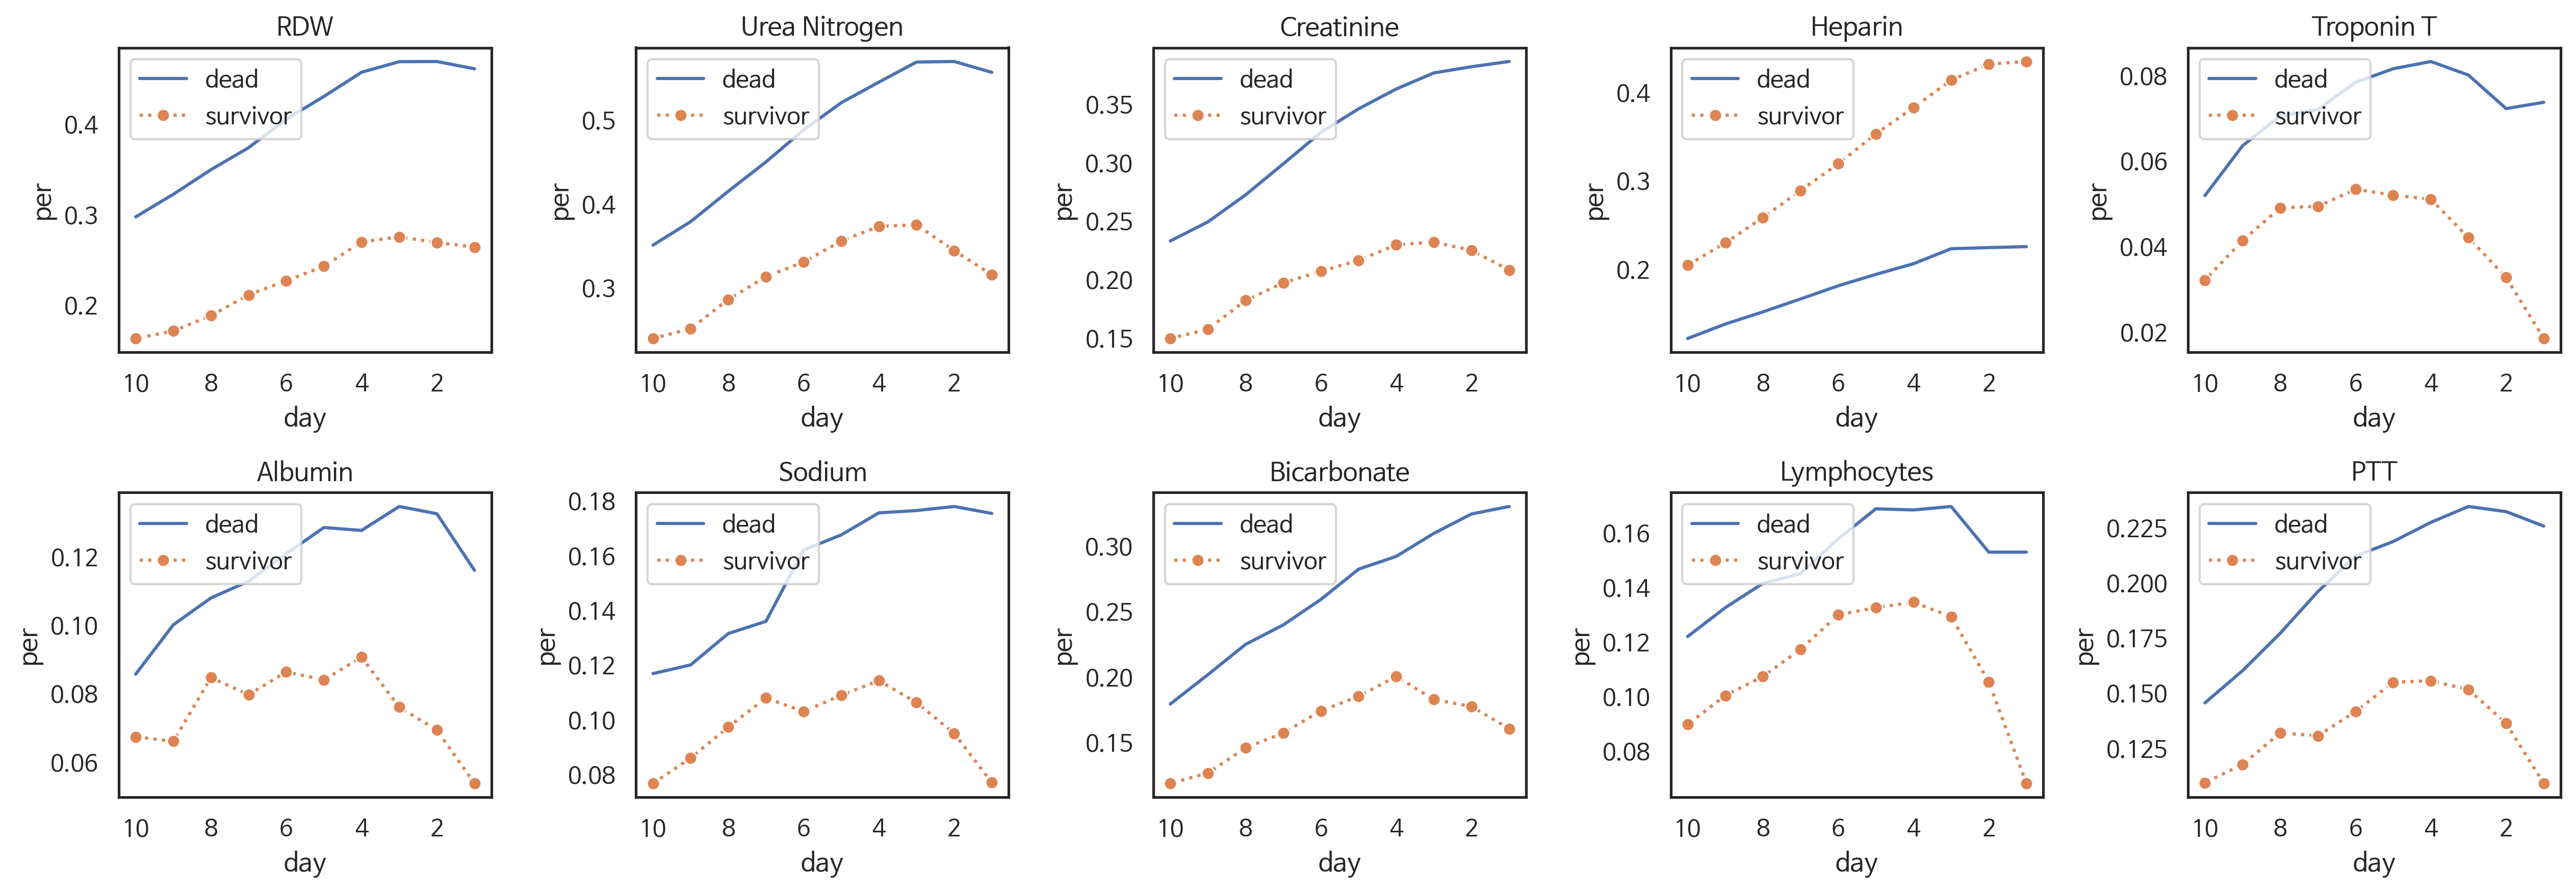

In [5]:
df = pd.read_csv('RF_FI_3595.csv')
absum(df['feature'][:10])

# RF - ② permutation
- Permutation-based importance is computationally expensive.
- It may have issues with features that are highly correlated, potentially reporting them as unimportant.

## x_(7727, 4068)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
import shap

import random  
seed_num = 42
random.seed(seed_num)

x = np.load('x_(7727,4068).npy')
y = np.load('/project/LSH/y_(7727,1).npy')

idx = list(range(len(x)))
random.shuffle(idx)

i = round(x.shape[0]*0.8)
X_train, y_train = x[idx[:i],:], y[idx[:i]]
X_test, y_test = x[idx[i:],:], y[idx[i:]]

X_train.shape, y_train.shape, X_test.shape, y_test.shape

,feature,score
206,51277,0.006472
56,50912,0.004790
34,50882,0.004790
48,50902,0.004531
2189,409490234,0.004531
2195,409606211,0.004272
2148,409176230,0.004013
119,51003,0.003625
155,51144,0.003366
95,50971,0.003366


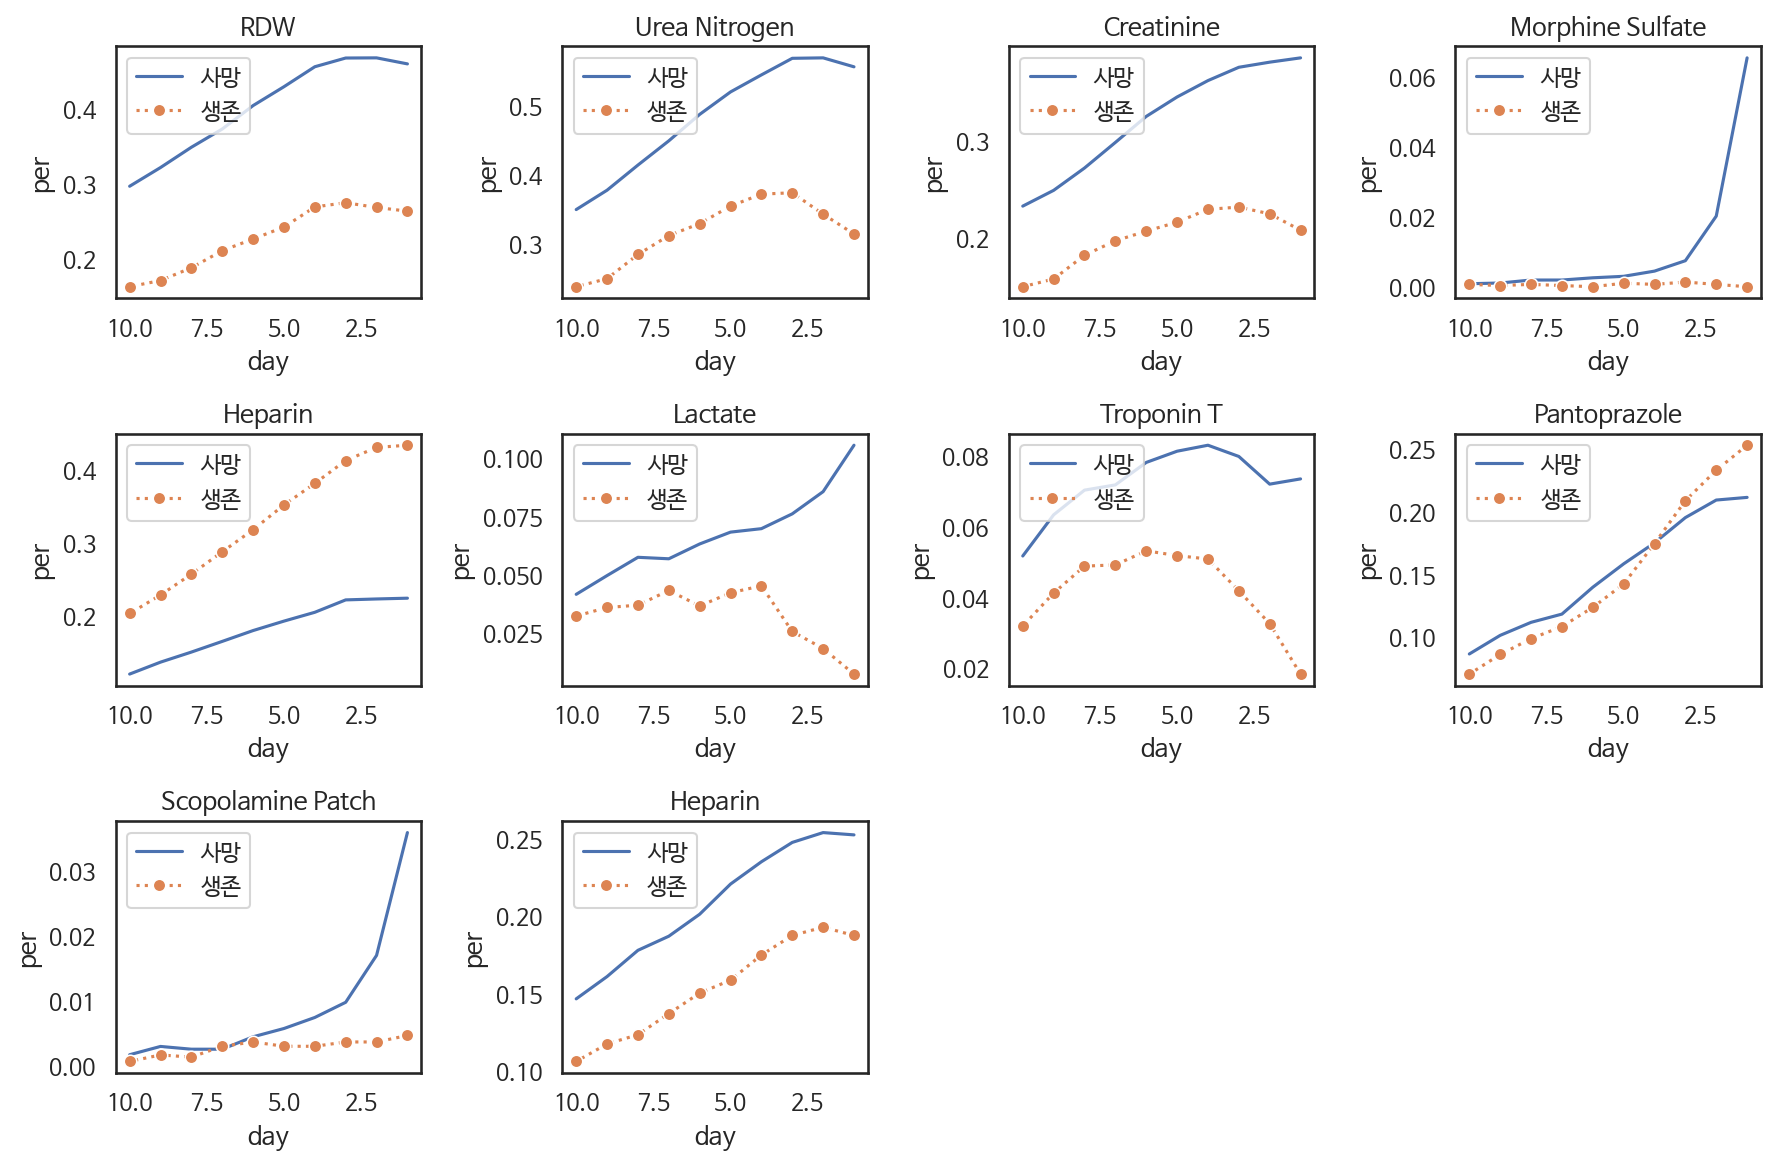

In [90]:
# 1. Create FI df
perm_importance = permutation_importance(model, X_test, y_test)

features = list(pd.read_csv('/project/LSH/total_data_7727.csv')['ITEMID'].sort_values().unique())
df = pd.DataFrame(features, columns=['feature'])
df['score'] = perm_importance.importances_mean
df = df.sort_values(by = 'score', ascending = False)

df[:10]
# df.to_csv('RF_per_FI_4068.csv', index = False)

# 2. absum graph
df = pd.read_csv('RF_per_FI_4068.csv')
absum(df['feature'][:10])

## x_(7727, 3595)

In [96]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
import shap

import random  
seed_num = 42
random.seed(seed_num)

x = np.load('x_(7727,3595).npy')
y = np.load('/project/LSH/y_(7727,1).npy')

idx = list(range(len(x)))
random.shuffle(idx)

i = round(x.shape[0]*0.8)
X_train, y_train = x[idx[:i],:], y[idx[:i]]
X_test, y_test = x[idx[i:],:], y[idx[i:]]

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((6182, 3595), (6182,), (1545, 3595), (1545,))

,feature,score
0,51277,0.015016
1,51274,0.004401
2,409606211,0.003883
3,338500241,0.003495
4,338004904,0.002589
5,67434504,0.002460
6,74781124,0.002460
7,409176230,0.002201
8,10019055302,0.002201
9,50806,0.002201


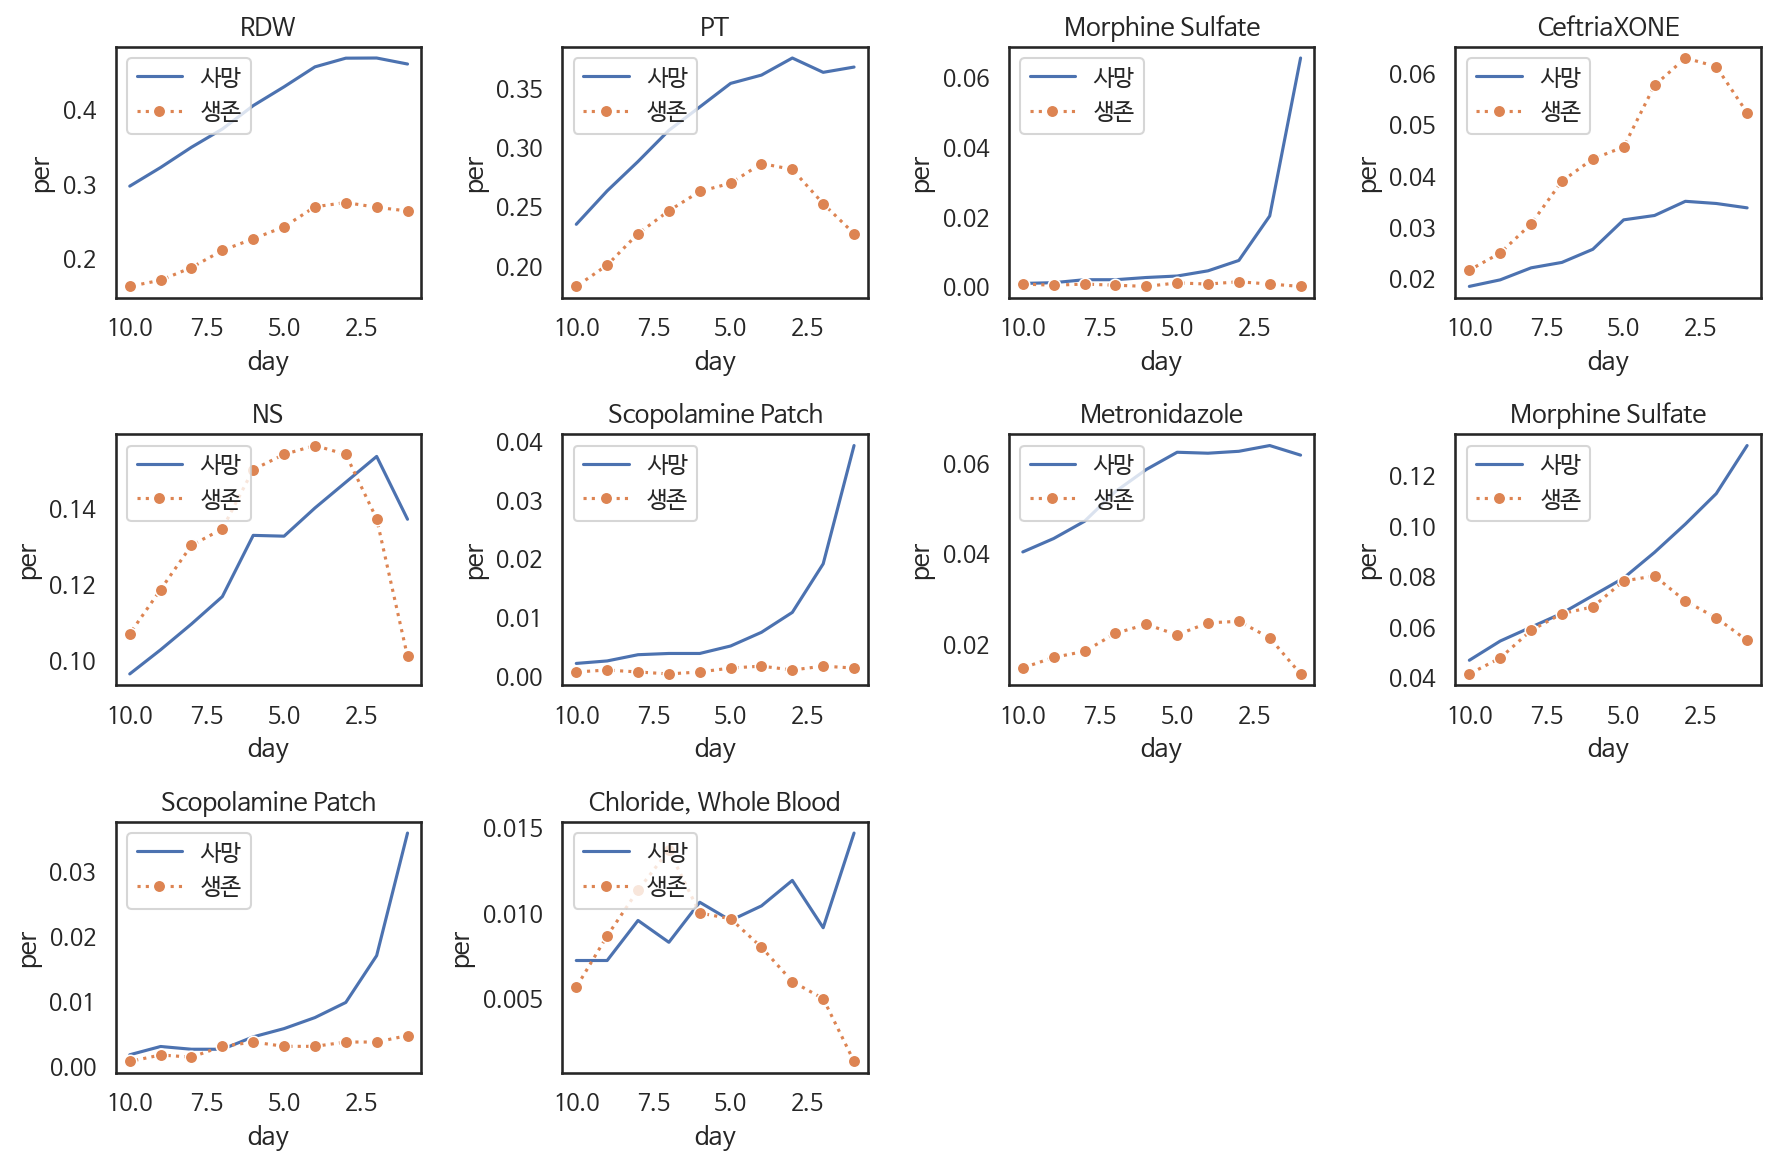

In [100]:
# 1. Create FI df
model = RandomForestClassifier()
model.fit(X_train, y_train)
perm_importance = permutation_importance(model, X_test, y_test)

features = list(pd.read_csv('total_data_7727_10_3595.csv')['ITEMID'].sort_values().unique())
df = pd.DataFrame(features, columns=['feature'])
df['score'] = perm_importance.importances_mean
df = df.sort_values(by = 'score', ascending = False)
df[:10]

# df.to_csv('RF_per_FI_3595.csv', index = False)

# 2. absum graph
df = pd.read_csv('RF_per_FI_3595.csv')
absum(df['feature'][:10])

# Permutation

## x_(7727, 10, 3595)

In [ ]:
# 1) DATA
import random    
seed_num = 42
random.seed(seed_num)

x = np.load('x_(7727,10,3595).npy')
y = np.load('/project/LSH/y_(7727,1).npy')

idx = list(range(len(x)))
random.shuffle(idx)

i = round(x.shape[0]*0.8)
X_train, y_train = x[idx[:i],:,:], y[idx[:i]]
X_test, y_test = x[idx[i:],:,:], y[idx[i:]]

X_train.shape, y_train.shape, X_test.shape, y_test.shape

df = pd.read_csv('total_data_7727_10_3595.csv')
features = list(df['ITEMID'].sort_values().unique())

# 2) MODEL
from keras.models import load_model
lstm2 = load_model('./model/f3595-06-val_loss:0.5522.hdf5')

# 3) COMPUTE BASELINE (NO SHUFFLE)
results = []
base_preds = lstm2.predict(X_test, verbose=0)
from tensorflow.keras.losses import BinaryCrossentropy
bce = BinaryCrossentropy()
baseline_bce = bce(y_test, base_preds).numpy()
results.append({'feature':'BASELINE','baseline_bce':baseline_bce}) 

with tf.device('/device:GPU:1'):
    
    for k in tqdm(range(len(features))):

        # 4) SHUFFLE FEATURE K
        save_col = X_test[:,:,k].copy()
        np.random.shuffle(X_test[:,:,k])

        # 5) COMPUTE BCE WITH FEATURE K SHUFFLED
        preds = lstm2.predict(X_test, verbose=0)
        loss_bce = bce(y_test, preds).numpy()

        results.append({'feature':features[k],'bce':loss_bce})
        X_test[:,:,k] = save_col

# 6) DISPLAY LSTM FEATURE IMPORTANCE
df = pd.DataFrame(results)

((6182, 10, 3595), (6182,), (1545, 10, 3595), (1545,))

Using TensorFlow backend.


  0%|          | 0/3595 [00:00<?, ?it/s]

In [ ]:
# df.to_csv('per_FI_3595.csv', index = False)

In [3]:
df = pd.read_csv('per_FI_3595.csv')
df['baseline_bce'] = float(df['baseline_bce'].dropna().unique())
df['diff'] = df['bce']-df['baseline_bce']
df = df.sort_values(by='diff')
df[:10]

,feature,baseline_bce,bce,diff
191,51253,0.98698,0.980203,-0.006776
111,50993,0.98698,0.980506,-0.006473
3393,54569281400,0.98698,0.981290,-0.005689
3081,51079009520,0.98698,0.984019,-0.002961
53,50908,0.98698,0.984121,-0.002858
32,50877,0.98698,0.984943,-0.002037
39,50890,0.98698,0.985120,-0.001859
1383,78031154,0.98698,0.985371,-0.001609
1971,310075139,0.98698,0.985381,-0.001599
3090,51079013120,0.98698,0.985382,-0.001598


,feature,baseline_bce,bce,diff
1820,338070341,0.98698,0.988771,0.001792
560,8084199,0.98698,0.988555,0.001575
1347,88222033,0.98698,0.988006,0.001026
2077,517260225,0.98698,0.987930,0.000950
2081,517391025,0.98698,0.987871,0.000891
2203,641040025,0.98698,0.987799,0.000819
1175,74665305,0.98698,0.987654,0.000675
2016,456066270,0.98698,0.987643,0.000664
1342,88120806,0.98698,0.987640,0.000660
1814,338055318,0.98698,0.987574,0.000594


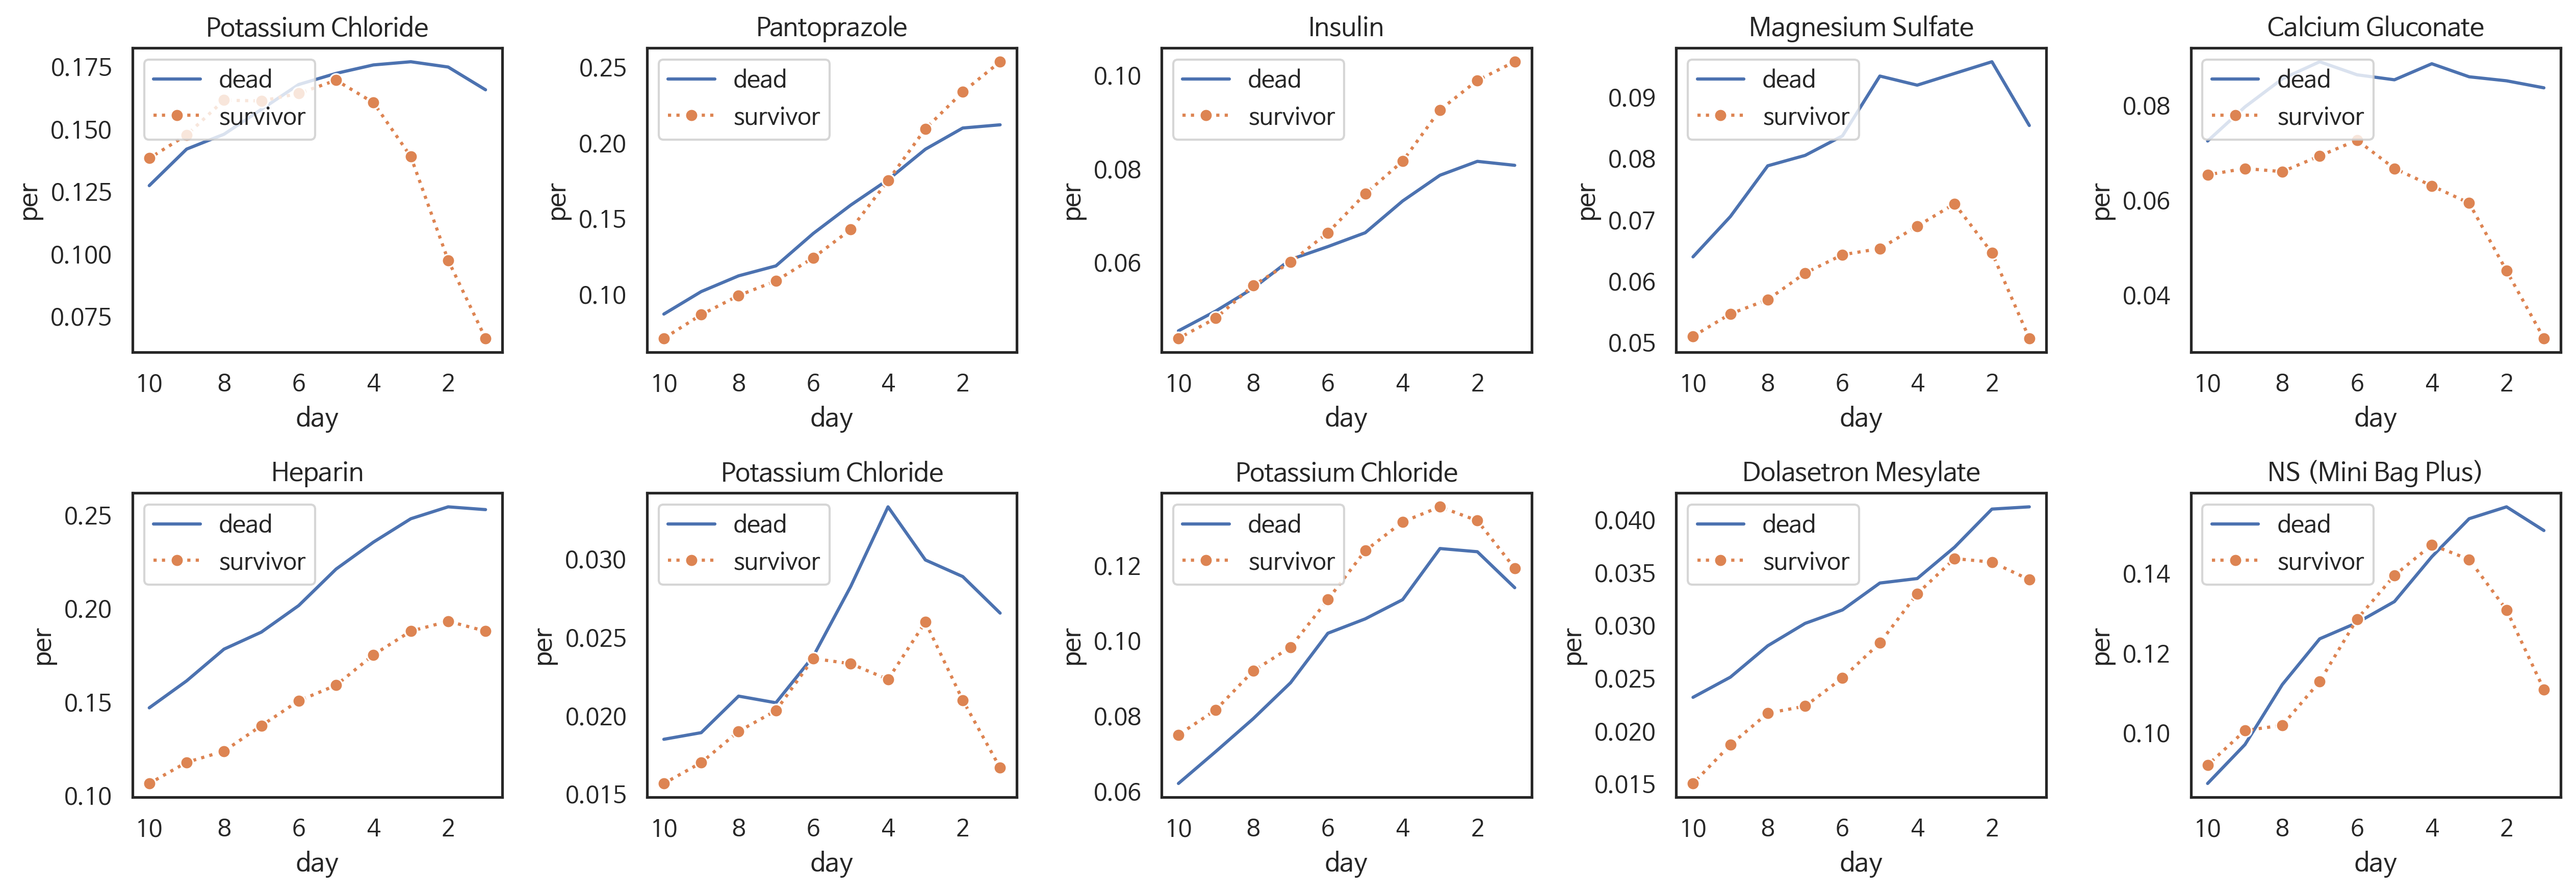

In [5]:
df = pd.read_csv('per_FI_3595.csv')
df['baseline_bce'] = float(df['baseline_bce'].dropna().unique())
df['diff'] = df['bce']-df['baseline_bce']
df = df.sort_values(by='diff', ascending = False)
df[:10]

# Descending order
absum(list(map(int,df[:10]['feature'])))

## Final shape : (2, 5)

,feature,baseline_bce,bce,diff
1820,338070341,0.98698,0.988771,0.001792
560,8084199,0.98698,0.988555,0.001575
1347,88222033,0.98698,0.988006,0.001026
2077,517260225,0.98698,0.987930,0.000950
2081,517391025,0.98698,0.987871,0.000891
2203,641040025,0.98698,0.987799,0.000819
1175,74665305,0.98698,0.987654,0.000675
2016,456066270,0.98698,0.987643,0.000664
1342,88120806,0.98698,0.987640,0.000660
1814,338055318,0.98698,0.987574,0.000594


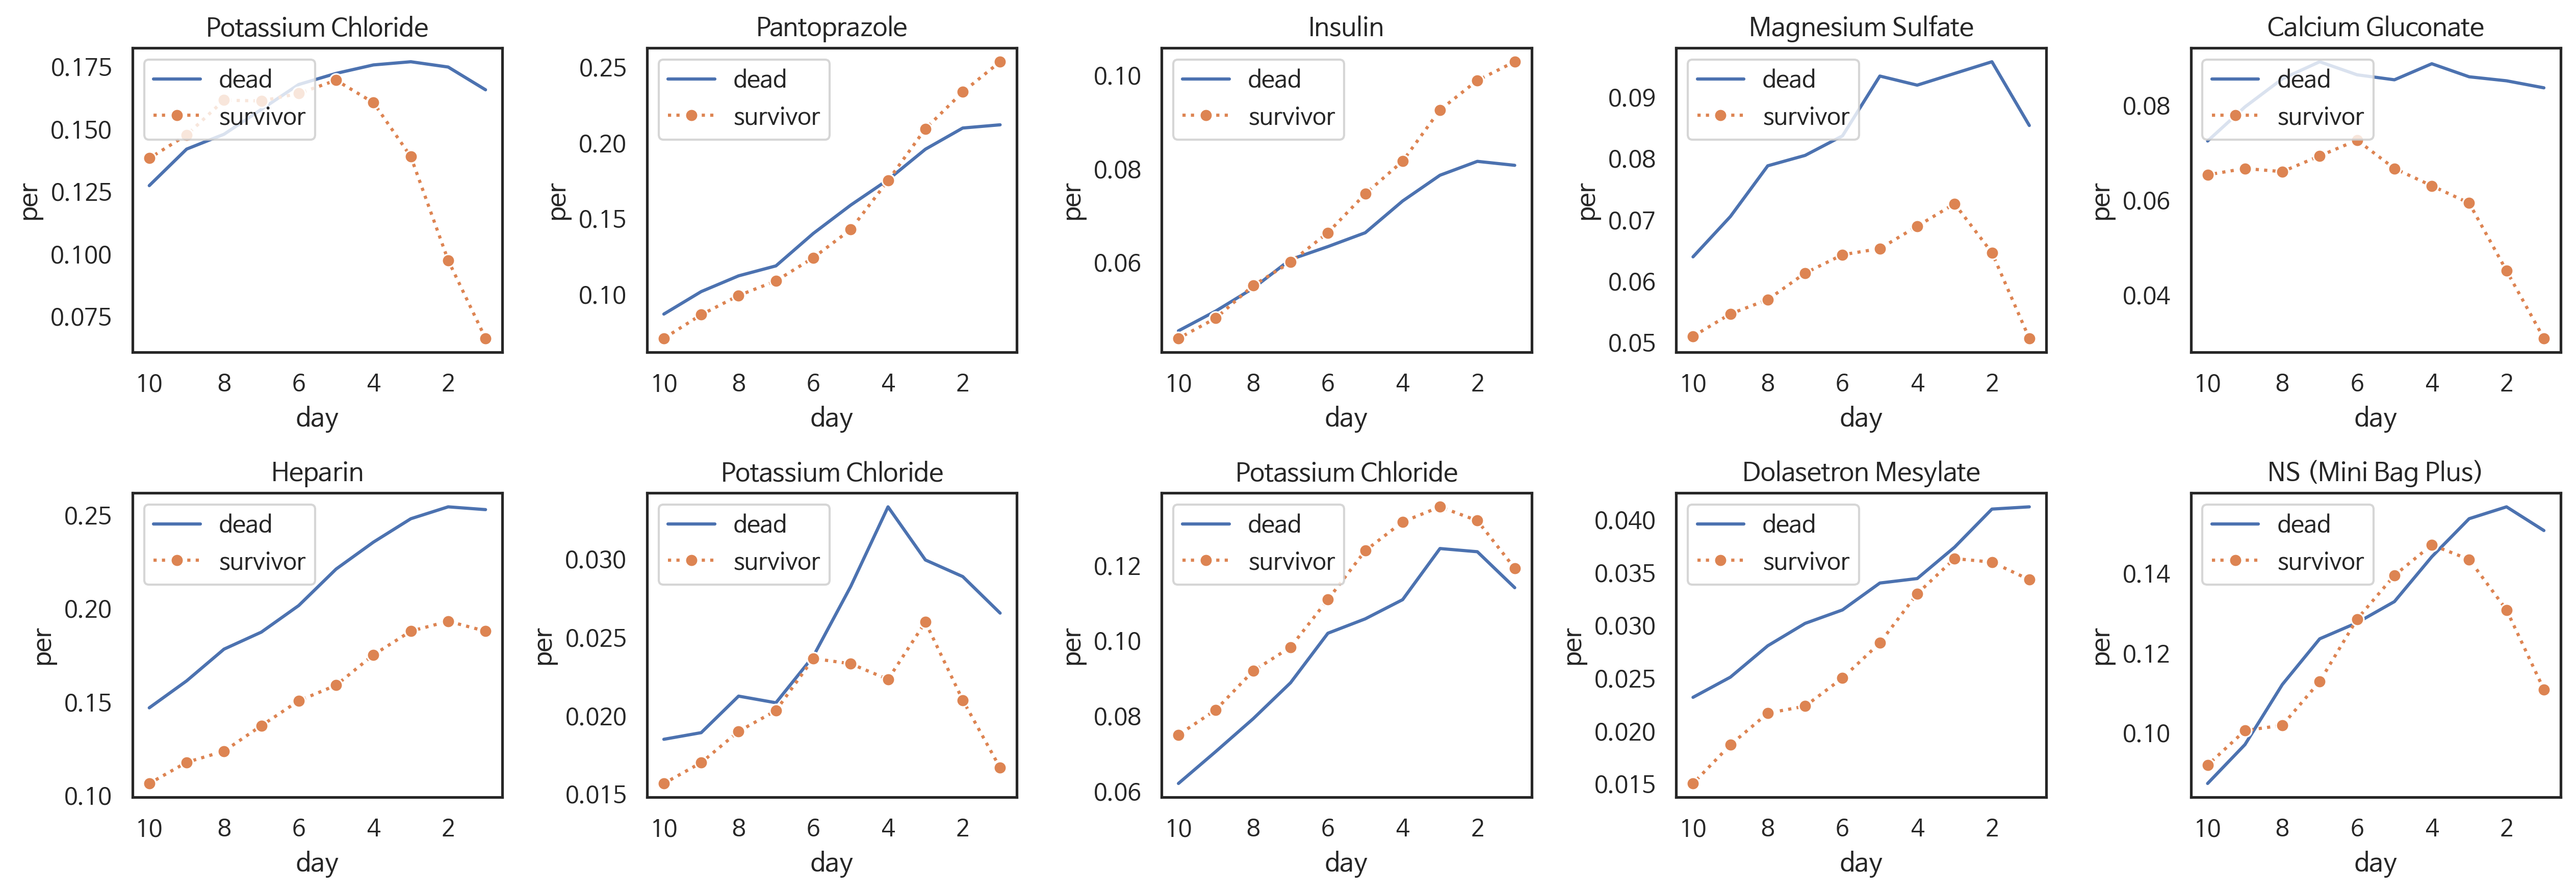

In [6]:
df = pd.read_csv('per_FI_3595.csv')
df['baseline_bce'] = float(df['baseline_bce'].dropna().unique())
df['diff'] = df['bce']-df['baseline_bce']
df = df.sort_values(by='diff', ascending = False)
df[:10]
absum(list(map(int,df[:10]['feature'])))

## x_(7727, 10, 4068)

In [4]:
# 1) DATA
import random    
seed_num = 42
random.seed(seed_num)

x = np.load('x_(7727,10,4068).npy')
y = np.load('/project/LSH/y_(7727,1).npy')

idx = list(range(len(x)))
random.shuffle(idx)

i = round(x.shape[0]*0.8)
X_train, y_train = x[idx[:i],:,:], y[idx[:i]]
X_test, y_test = x[idx[i:],:,:], y[idx[i:]]

X_train.shape, y_train.shape, X_test.shape, y_test.shape

df = pd.read_csv('/project/LSH/total_data_7727.csv')
features = list(df['ITEMID'].sort_values().unique())

# 2) MODEL
from keras.models import load_model
lstm2 = load_model('./model/seed42-06-val_loss:0.5523.hdf5')

# 3) COMPUTE BASELINE (NO SHUFFLE)
results = []
base_preds = lstm2.predict(X_test, verbose=0)
from tensorflow.keras.losses import BinaryCrossentropy
bce = BinaryCrossentropy()
baseline_bce = bce(y_test, base_preds).numpy()
results.append({'feature':'BASELINE','baseline_bce':baseline_bce}) 

with tf.device('/device:GPU:1'):
    
    for k in tqdm(range(len(features))):

        # 4) SHUFFLE FEATURE K
        save_col = X_test[:,:,k].copy()
        np.random.shuffle(X_test[:,:,k])

        # 5) COMPUTE BCE WITH FEATURE K SHUFFLED
        preds = lstm2.predict(X_test, verbose=0)
        loss_bce = bce(y_test, preds).numpy()

        results.append({'feature':features[k],'bce':loss_bce})
        X_test[:,:,k] = save_col

# 6) DISPLAY LSTM FEATURE IMPORTANCE
df2 = pd.DataFrame(results)
df2.to_csv('per_FI_4068.csv', index = False)

In [10]:
df = pd.read_csv('per_FI_4068.csv')
df['baseline_bce'] = float(df['baseline_bce'].dropna().unique())
df['diff'] = df['bce']-df['baseline_bce']
df = df.sort_values(by='diff')
df[:10]

,feature,baseline_bce,bce,diff
207,51277,0.981843,0.975254,-0.006590
122,51006,0.981843,0.977432,-0.004412
3833,63323026201,0.981843,0.978156,-0.003688
2149,409176230,0.981843,0.979186,-0.002657
35,50882,0.981843,0.979571,-0.002273
2190,409490234,0.981843,0.979891,-0.001953
2389,574705050,0.981843,0.979989,-0.001854
3457,55390000401,0.981843,0.980047,-0.001796
3469,55390007310,0.981843,0.980120,-0.001723
2291,487950125,0.981843,0.980152,-0.001691


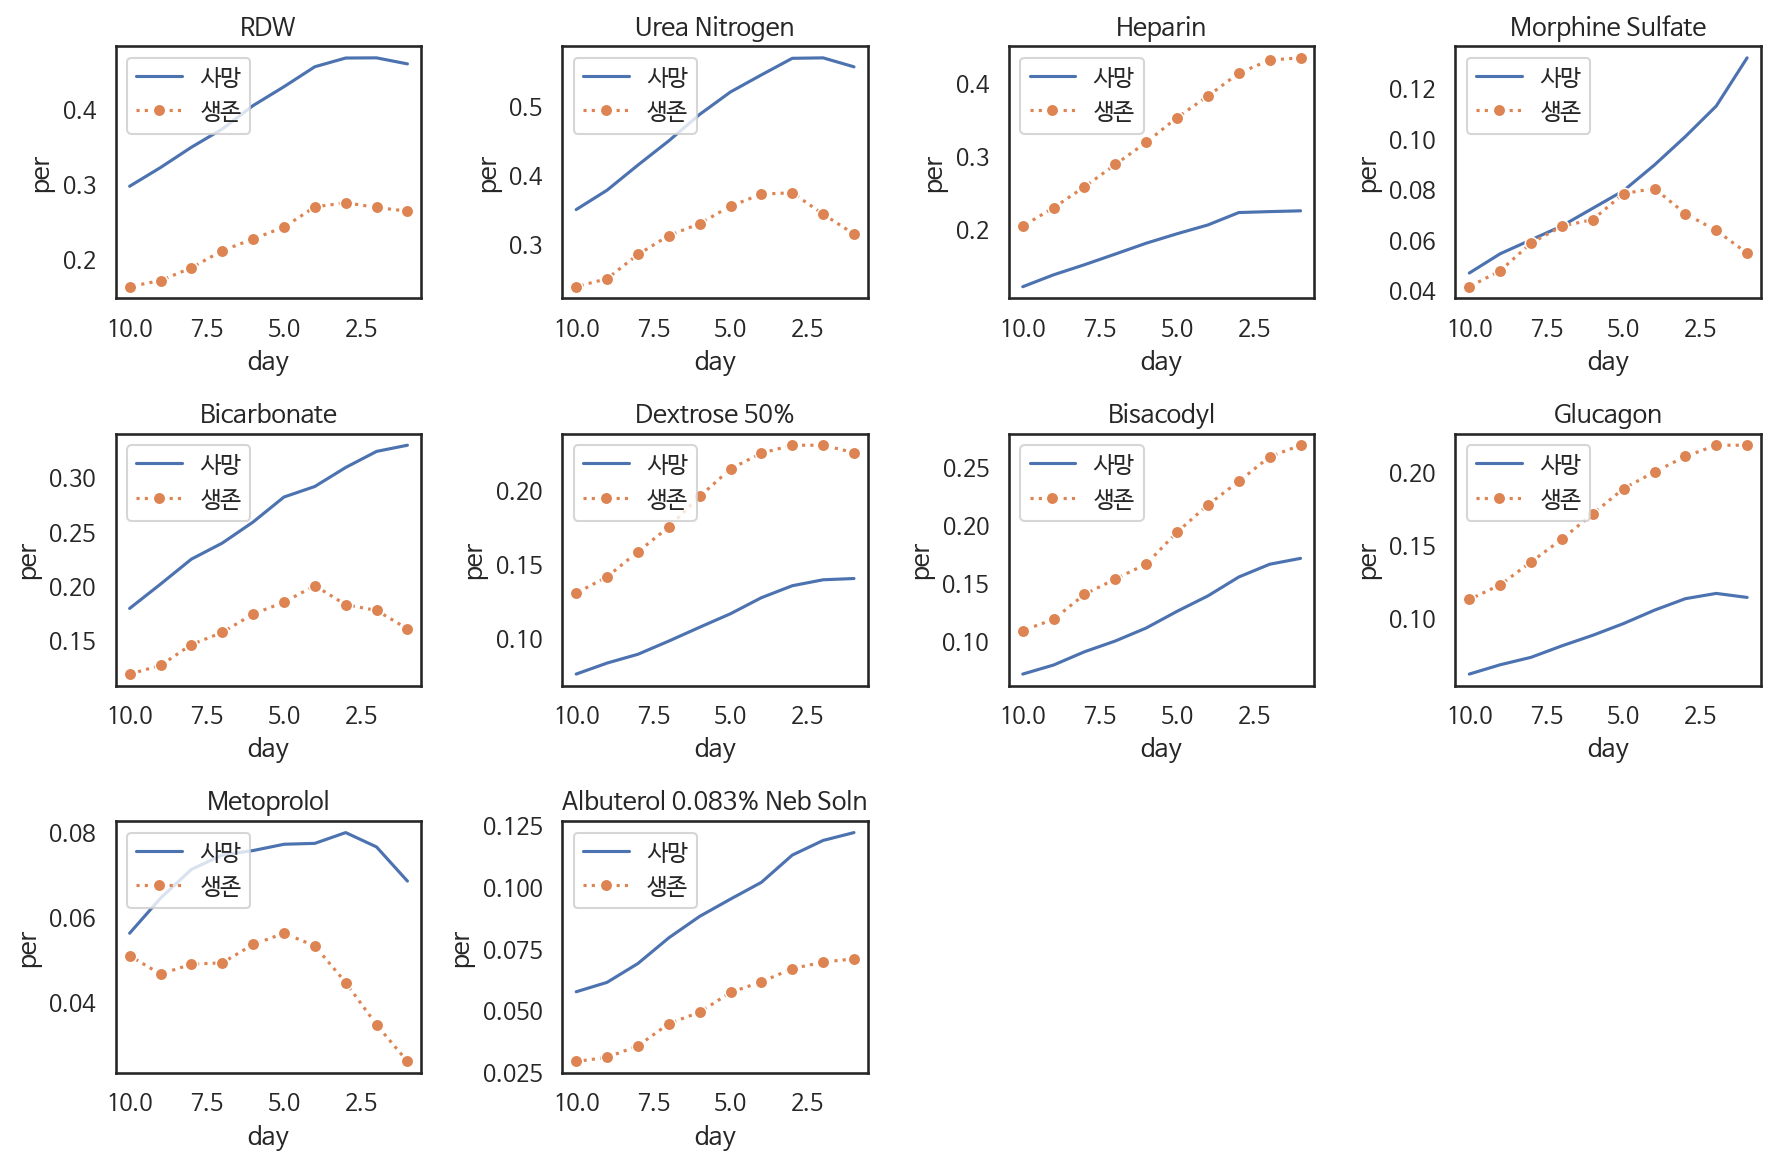

In [13]:
absum(list(map(int, df[:10]['feature'])))